## Overview:  
This notebook will give you a quick example of how you can work with output generated from BLAST running over OMXWare data.

## Notes:
- You can download the CSV output for your search query to BLAST in the OMXWare Hub UI.
- A sample output file is included in the `Example-Data` directory in this repository as well.


In [17]:
%matplotlib inline

import omxware

import pandas as pd
import matplotlib.pylab as plt

import seaborn as sns
import pprint

import plotly.express as px

# --- Authentication options --- #
# generate token with OMXWare user name and password (likely done once and then stored in file, see usage below)
# token = omxware.getToken('username', '<pw>') # fill in password to initiate token

# or

# use previously generated token loaded from file
token_path = "./omxware_collaborative_work/super_awesome_token"  # update for your path to the token file you create
f = open(token_path)
token = f.readline()

# provide your token to authenticate with OMXWare
omx = omxware.omxware(token)


### Import BLAST results from CSV

In [18]:
hits = pd.read_csv("./Example-Data/blast_results_example.csv")

hits.head()


,query_def,omx_id,type,name,hspscore,hspbitscore,hspalignlen,hspevalue,hsphseq,hspqueryfrom,hspqueryto,hspgaps,percentidentity
0,dataset_121199-consensus,921db25406f80e09c8f78dd915f355aa,gene,Glutamine synthetase,329,608.668,1349,3.822150e-170,TGATCAAAGAACACGACGTGAAGTGGGTAGACCTGCGCTTCACCGA...,24,1341,53,75.463306
1,dataset_121199-consensus,b1eb6e454a5fed16e98c96999926ec3e,gene,Glutamine synthetase,326,603.128,1349,1.778270e-168,TGATCAAAGAACACGACGTGAAGTGGGTAGACCTGCGCTTCACCGA...,24,1341,53,75.389177
2,dataset_121199-consensus,b689b19fdb3750bac6a66b6c419bd6e0,gene,Glutamine synthetase,305,564.348,1345,8.391400e-157,TTCTGAAGCAAATCAAGGACAACGACGTCAAGTTCGTCGACCTGCG...,15,1326,63,75.018587
3,dataset_121199-consensus,bcee20a35c4fd8990bcf3d6fb1544bb6,gene,Glutamine synthetase,303,560.655,1357,1.085500e-155,AAGAAGTCCTGAA-ATCCATCAAGGACAACGACGTGAAATACGTCG...,9,1327,73,75.018423
4,dataset_121199-consensus,72edf7cb3082dcf27cd32b0bf5cf8e2e,gene,Glutamine synthetase,299,553.269,1345,1.816420e-153,TTCTGAAGCAAATCAAGGACAACGACGTCAAGTTCGTCGACCTGCG...,15,1326,63,74.869888


### Results explanation:
`query_def`: query from input string or header sequence provided fasta file  
`omx_id`: OMXWare unique identifier for gene (if using nucleotide BLAST) or protein (if using protein BLAST). This can be used as a query for other OMXWare data connections  
`type`: type of sequence matching the query sequence  
`name`: name of sequence match from OMXWare  

*Remaining fields are amply described in BLAST documentation and will not be replicated here.*  
[NCBI BLAST+ documentation](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastDocs)


### Explore and plot gene name results

Glutamine synthetase             340
Glutamine synthetase 1           108
Glutamate--methylamine ligase     15
3-hydroxylaminophenol mutase       9
Thiamine-monophosphate kinase      1
Name: name, dtype: int64


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

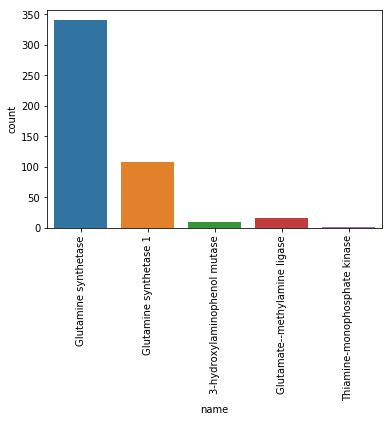

In [19]:
# frequency table of gene names
print(hits['name'].value_counts())

# plot histogram of gene names
sns.countplot(hits['name'])
plt.xticks(rotation=90)


### Retrieve related data from OMXWare

The BLAST results table above provides the 'matching substring' from the resulting gene sequence. What if we're interested in the full gene sequence? We can retrieve that easily with the OMXWare client.  

Choose a gene unique identifier (`omx_id`) from the list above and invoke an `omxware` function to retrieve the gene details.

In [40]:
working_gene = omx.genes(hits['omx_id'][0]).results(type="fasta")

# Show the gene sequence
print(working_gene)

>OMX_gene_921db25406f80e09c8f78dd915f355aa|Glutamine synthetase
ATGTCGAAGTCGATTCAACTGATCAAAGAACACGACGTGAAGTGGGTAGACCTGCGCTTCACCGATACCAAAGGCAAGCAGCAGCACGTGACCATCCCTGCCCGTGAAGCGCTGGACGAAGATTTCTTCGAGCACGGCAAGATGTTCGACGGCTCCTCCATCGCCGGCTGGAAAGGCATCGAAGCCTCCGACATGATCCTCATGCCGGACGACAGCACCGCCGTGCTGGACCCCTTCACCGAAGAGCCGACCCTGATCCTGGTCTGCGACATCATCGAGCCCTCCACCATGCAGGGCTACGACCGTGACCCGCGCGCCATCGCCCGTCGCGCCGAGGAATACCTGAAGTCCACCGGCATCGGCGACACCGCCTTCTTCGGTCCGGAACCGGAGTTCTTCATCTTCGACGAAGTGAAGTTCAAGTCCGACATCTCCGGCTCCATGTTCAAGATCTACTCCGAACAGGCTGCCTGGAACACCGACGCCTCCTTCGAGAGCGGCAACAAGGGCCACCGCCCGGGCGTCAAGGGCGGTTACTTCCCGGTTCCGCCGGTCGACCACGACCACGAAATCCGCACCGCCATGTGCAACGCTCTGGAAGAGTTCGGCCTCAAGGTTGAAGTGCACCACCACGAGGTGGCCACCGCCGGCCAGAACGAGATCGGCGTCAGCTTCAACACCCTGGTGAAGAAGGCCGACGAAGTGCAGACCCTGAAGTACGTGGTGCACAACGTCGCCGACGCCTACGGCAAGACCGCTACCTTCATGCCGAAGCCGCTGTACGGCGACAACGGCTCGGGCATGCACGTGCACATGTCCATCGCCAAGGACGGCAAGAACACCTTCGCCGGTGAAGGCTATGCCGGCCTGTCCGAGACCGCCCTGTACTTCATCGGCGGCATCATCAAGCACGGCAAGGCCCTGAACAGCTTCACC

__Where else are these genes observed?__

In [70]:
# Now, we can see which genera this sequence was found in.  

gene_ids = (hits['omx_id'][0:200]).tolist()  # must provide input to omxware as a list, not a series
# print(gene_ids)
genus_hits = omx.genes(ids=gene_ids).facets()["genera"]

genus_frequency = pd.DataFrame(genus_hits)

# visualize genus frequency
fig = px.bar(genus_frequency, x='name', y='count')
fig.show()